# Example 2: Applying an error detection algorithm to a full dataset
_Created by Davíd Brakenhoff, Artesia, May 2020_

<hr>

Use Aa en Maas divers dataset consisting of 484 piezometers to test new traval module.
- Requires pystore
- Requires hydropandas
- Requires data in pystore format as prepared by scripts in the `traval_data` module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystore
from tqdm.notebook import tqdm

import hydropandas as hpd

import sys
sys.path.insert(1, "../..")
import traval
from traval import rulelib as rlib

## Load data

In [2]:
pystore_path = "/home/david/Github/traval-data/extracted_data/pystore"
pystore_name = "aaenmaas"

In [3]:
items = ["GW.meting.ruw"]
raw_obs = hpd.ObsCollection.from_pystore(pystore_name, 
                                        pystore_path, 
                                        collection_names=None, 
                                        item_names=items, 
                                        nameby="collection", 
                                        read_series=True,
                                        verbose=False, 
                                        progressbar=True)

items = ["GW.meting.totaalcorrectie"]
val_obs = hpd.ObsCollection.from_pystore(pystore_name, 
                                        pystore_path, 
                                        collection_names=None, 
                                        item_names=items, 
                                        nameby="collection", 
                                        read_series=True,
                                        verbose=False, 
                                        progressbar=True)

100%|██████████| 484/484 [00:21<00:00, 22.16it/s]


## Helper functions for obtaining additional timeseries

In [4]:
pystore.set_path(pystore_path)
store = pystore.store(pystore_name)

def get_mph_series(name):
    coll = store.collection(name)
    meetpuntNAP_df = coll.item('Meetpunt.hoogte').to_pandas()
    return meetpuntNAP_df.value


def get_threshold_series(name):
    coll = store.collection(name)
    inhangdiepte_df = coll.item('Inhang.diepte').to_pandas()
    inhangdiepte = inhangdiepte_df.value.iloc[0]
    meetpuntNAP_df = coll.item('Meetpunt.hoogte').to_pandas()
    meetpuntNAP = meetpuntNAP_df.value.iloc[0]
    threshold_series = meetpuntNAP_df.value - inhangdiepte_df.value
    return threshold_series

## Define error detection algorithm
BASIC method from TRAVAL study.

In [5]:
# initialize RuleSet object
rset = traval.RuleSet(name="basic")

# add rules
rset.add_rule("spikes", rlib.rule_spike_detection, apply_to=0, kwargs={"threshold": 0.15, "spike_tol": 0.15, "max_gap": "7D"})
rset.add_rule("dry", rlib.rule_ufunc_threshold, apply_to=0, kwargs={"ufunc": (np.less,), "threshold": get_threshold_series, "offset": 0.05})
rset.add_rule("hardmax", rlib.rule_ufunc_threshold, apply_to=0, kwargs={"ufunc": (np.greater,), "threshold": get_mph_series})
rset.add_rule("combine", rlib.rule_combine_nan, apply_to=(1, 2, 3))

# view object
rset

RuleSet: 'basic'
  step: name            apply_to
     1: spikes                 0
     2: dry                    0
     3: hardmax                0
     4: combine         (1, 2, 3)

## Error detection

Do some pre-processing on timeseries prior to running error detection:
- Create synthetic raw timeseries (remove unlabeled adjustments to timeseries)
- Ensure all labeled errors are set to np.nan in truth series (this means they are counted as erroneous observations).
- Recategorize some comments.


In [6]:
dlist = {}

for name in tqdm(raw_obs.index.intersection(val_obs.index)):
    
    # get raw data
    raw = raw_obs.loc[name, "obs"]["value"]
    raw.name = name
    
    # get truth
    truth = val_obs.loc[name, "obs"].loc[:, ["value", "comment"]]
    
    # set all commented data to np.NaN
    truth.loc[truth.comment != "", "value"] = np.nan
    truth.loc[truth.comment == "vorst", "comment"] = "onbetrouwbare meting"
    
    # rename columns
    truth.columns = ["manual validation", "comment"]
    
    # create synthetic raw
    synth_raw = traval.ts_utils.create_synthetic_raw_timeseries(raw, truth["manual validation"], truth["comment"])
    synth_raw.name = name
    
    # create detector object and apply algorithm
    detector = traval.Detector(synth_raw, truth=truth)
    detector.apply_ruleset(rset, compare=[-1])
    
    # store object
    dlist[name] = detector

## Calculate statistics
For full dataset and for individual timeseries

In [7]:
fpr = []
tpr = []

# initialize empty BinaryClassifier
bc_sum = traval.BinaryClassifier(0, 0, 0, 0)

for k, dct in dlist.items():
    
    # get TPR and FPR
    itpr = dct.comparisons[4].bc.true_positive_rate
    ifpr = dct.comparisons[4].bc.false_positive_rate
    tpr.append(itpr)
    fpr.append(ifpr)
    
    # add binary classification result
    bc_sum = bc_sum + dct.comparisons[4].bc

Calculate confusion matrix for full dataset

In [8]:
bc_sum.confusion_matrix?

Signature: bc_sum.confusion_matrix(as_array=False)
Docstring:
Calculate confusion matrix.

Confusion matrix shows the performance of the algorithm given a
certain truth. An abstract example of the confusion matrix:

                |     Algorithm     |
                |-------------------|
                |  error  | correct |
------|---------|---------|---------|
      |  error  |   TP    |   FN    |
Truth |---------|---------|---------|
      | correct |   FP    |   TN    |
------|---------|---------|---------|

where:
- TP: True Positives  = errors correctly detected by algorithm
- TN: True Negatives  = correct values correctly not flagged by algorithm
- FP: False Positives = correct values marked as errors by algorithm
- FN: False Negatives = errors not detected by algorithm

Parameters
----------
as_array : bool, optional
    return data as array instead of DataFrame, by default False

Returns
-------
data : pd.DataFrame or np.array
    confusion matrix
File:      ~/Github/traval

In [9]:
bc_sum.confusion_matrix()

Algorithm          
                    error   correct
"Truth" error      442444    411828
        correct    319029  24651161

### ROC-plot

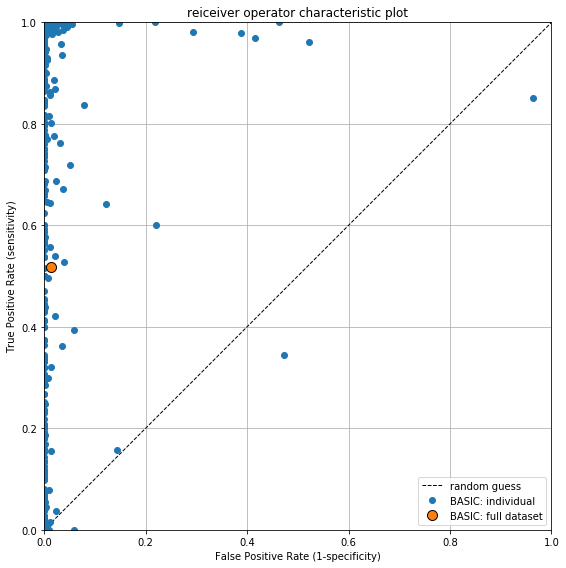

In [10]:
ax = traval.plots.roc_plot([np.array(tpr)], [np.array(fpr)], labels=["BASIC: individual"])
traval.plots.roc_plot(bc_sum.true_positive_rate, bc_sum.false_positive_rate, labels="BASIC: full dataset", 
                      ax=ax, plot_diagonal=False, ms=10, c="C1", mec="k")

True positive rate

In [11]:
bc_sum.true_positive_rate

0.517919351213665

Matthews Correlation Coefficient for full dataset.

In [12]:
bc_sum.mcc()

0.5340471787404938

Get statistics per comment

In [13]:
summ = None
for d in tqdm(dlist.values()):
    if summ is None:
        summ = d.comparisons[4].compare_to_base_by_comment()
    else:
        summ = summ.add(d.comparisons[4].compare_to_base_by_comment(), fill_value=0.0)

In [14]:
summ = summ.dropna(how="all", axis=0)
summ

,,drift logger,droog,foute meting,inhang,lucht,onbetrouwbare meting,piek
kept_in_both,24651161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s1,319029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s2,NaN,299331.0,24234.0,21559.0,9111.0,3361.0,48017.0,6215.0
flagged_in_both,NaN,31367.0,303194.0,23006.0,34652.0,15343.0,24959.0,9923.0


In [15]:
ratio = summ / summ.sum()
ratio

,,drift logger,droog,foute meting,inhang,lucht,onbetrouwbare meting,piek
kept_in_both,0.987224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s1,0.012776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s2,NaN,0.905149,0.074013,0.483765,0.20819,0.179694,0.657983,0.385116
flagged_in_both,NaN,0.094851,0.925987,0.516235,0.79181,0.820306,0.342017,0.614884


Plot barchart showing error detection rate per comment.

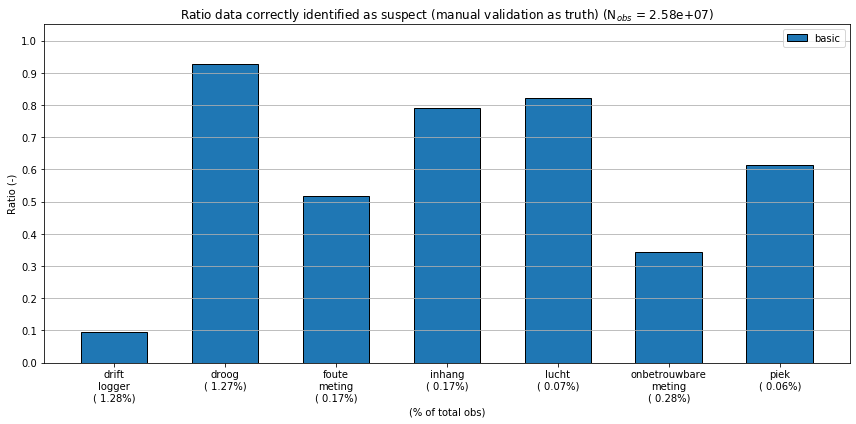

In [16]:
lbls = list((ratio.columns.str.replace(" ", "\n") + 
             summ.sum().apply(lambda s: "\n({0:>6.2%})".format(s/bc_sum.n_obs))).values)

# create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bar = ax.bar(range(ratio.columns.size), ratio.loc["flagged_in_both"].values,
       align="center", width=0.6, edgecolor="k", label=rset.name)

ax.set_xticklabels(lbls)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Ratio (-)")
ax.grid(b=True, axis="y")
ax.legend(loc="upper right")
ax.set_title("Ratio data correctly identified as suspect "
             "(manual validation as truth) "
             "(N$_{{obs}}$ = {0:5.2e})".format(summ.sum().sum()))
plt.xticks(rotation=0, ha="center")
ax.set_ylim(0, 1.05)
ax.set_xlabel("(% of total obs)")

fig.tight_layout()